# Regression analysis



In [51]:
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools
from matplotlib import pyplot as plt
import glob
import scipy
from modules import *
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

We want to apply the following to the data:

    1) Find the anomalies
    2) Get the annual average
    3) Normalise the indepenant variables

In [19]:
# files = glob.glob('processed_data/*')
# files = [f for f in files if '_' not in f.split('\\')[1]]
# ds = xr.open_mfdataset(files, chunks = {'x':100,'y':100})

In [20]:
# ds

<xarray.Dataset>
Dimensions:  (time: 503, x: 316, y: 332)
Coordinates:
  * time     (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2020-09-01
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
Data variables:
    si10     (time, y, x) float64 dask.array<where, shape=(503, 332, 316), dt...
    sic      (time, y, x) float64 dask.array<where, shape=(503, 332, 316), dt...
    skt      (time, y, x) float64 dask.array<where, shape=(503, 332, 316), dt...
    sp       (time, y, x) float64 dask.array<where, shape=(503, 332, 316), dt...
    ssr      (time, y, x) float64 dask.array<where, shape=(503, 332, 316), dt...
    ssrd     (time, y, x) float64 dask.array<where, shape=(503, 332, 316), dt...
    sst      (time, y, x) float64 dask.array<where, shape=(503, 332, 316), dt...
    t2m      (time, y, x) float64 dask.array<where, shape=(503, 332, 316), dt...
    u10      (time, y, x) float64 dask.array<where, shape=(503, 332, 316), dt...
    v10      (time, y, x) float64 dask.array<where, shape=(503, 332, 316), dt...

In [21]:
# ds = ds.sel(time=slice('1979-01-01','2019-12-31'))
# ds = (ds
#       .pipe(w5.find_anomalies)
#       .pipe(w5.yearly_average)
#       .pipe(w5.normalise_indepenant, dependant='sic')
#      )

# ds.to_netcdf('processed_data/temp.nc')

In [26]:
ds = xr.open_dataset('processed_data/temp.nc')

ds

<xarray.Dataset>
Dimensions:  (time: 41, x: 316, y: 332)
Coordinates:
  * y        (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x        (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
  * time     (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
Data variables:
    si10     (time, y, x) float64 ...
    sic      (time, y, x) float64 ...
    skt      (time, y, x) float64 ...
    sp       (time, y, x) float64 ...
    ssr      (time, y, x) float64 ...
    ssrd     (time, y, x) float64 ...
    sst      (time, y, x) float64 ...
    t2m      (time, y, x) float64 ...
    u10      (time, y, x) float64 ...
    v10      (time, y, x) float64 ...

# Correlations

In [27]:
v = [v for v in ds]
correlation_matrix = pd.DataFrame(index=v,columns=v, dtype=np.float64)
for v1,v2 in tqdm(list(itertools.product(v,v))):
    vec1 = ds[v1].mean(dim=('x','y'))
    vec2 = ds[v2].mean(dim=('x','y'))
    correlation_matrix.loc[v1,v2]=xr.corr(vec1,vec2).values
    
def significant_bold(val, sig_level=0.9):
    bold = 'bold' if val > sig_level or val < -sig_level else ''
    return 'font-weight: %s' % bold
correlation_matrix.style.applymap(significant_bold,sig_level=0.9)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.36it/s]


,si10,sic,skt,sp,ssr,ssrd,sst,t2m,u10,v10
si10,1.000000,0.193010,-0.288634,-0.633299,0.267617,0.261235,-0.215486,-0.194827,0.812793,-0.687884
sic,0.193010,1.000000,-0.711762,-0.042341,0.012555,0.516434,-0.686655,-0.717692,0.140194,-0.065320
skt,-0.288634,-0.711762,1.000000,0.252163,-0.030236,-0.408460,0.872786,0.985089,-0.380605,0.219702
sp,-0.633299,-0.042341,0.252163,1.000000,0.005248,0.040735,0.024328,0.201595,-0.828970,0.549023
ssr,0.267617,0.012555,-0.030236,0.005248,1.000000,0.800952,-0.012657,-0.031298,0.038856,0.029796
ssrd,0.261235,0.516434,-0.408460,0.040735,0.800952,1.000000,-0.416684,-0.407482,0.012757,0.031371
sst,-0.215486,-0.686655,0.872786,0.024328,-0.012657,-0.416684,1.000000,0.822488,-0.149241,0.094133
t2m,-0.194827,-0.717692,0.985089,0.201595,-0.031298,-0.407482,0.822488,1.000000,-0.320275,0.136325
u10,0.812793,0.140194,-0.380605,-0.828970,0.038856,0.012757,-0.149241,-0.320275,1.000000,-0.796108
v10,-0.687884,-0.065320,0.219702,0.549023,0.029796,0.031371,0.094133,0.136325,-0.796108,1.000000


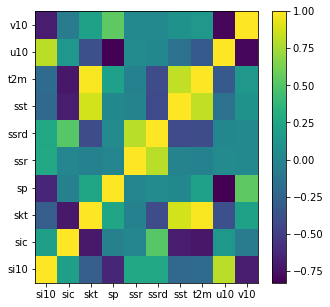

In [28]:
fig = plt.figure(figsize=(5,5))
plt.pcolormesh(correlation_matrix)
plt.colorbar()
plt.xticks(np.arange(0,len(v))+0.5,v)
plt.yticks(np.arange(0,len(v))+0.5,v)
plt.savefig('images/week5/correlations.pdf')
plt.show()

# running a NN model

In [34]:
data = ds.to_array()
data

<xarray.DataArray (variable: 10, time: 41, y: 332, x: 316)>
array([[[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.6131508 ,
           0.        ,  0.        ],
         ...,
         [-1.09057232, -1.09926061, -1.07988191, ...,  0.55111688,
           0.57866096,  0.60421579],
         [-1.05205788, -1.0712768 , -1.04440905, ...,  0.60500522,
           0.63175353,  0.66046367],
         [-1.00698211, -1.0138379 , -1.0130017 , ...,  0.61924118,
           0.64927661,  0.68411578]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ..., -0.2934944 ,
           0.        ,  0.        ],
...
         [ 0.21304658,  0.21673089,  0.21454254, ..., -0.70878455,
          -0.71231667, -0.7277004 ],
         [ 0.19429779,  0.19414073,  0.1891735 , ..., -0.65945262,
          -0.68865462, -0.70945101],
         [ 0.1765323 ,  0.17351284,  0.17636782, ..., -0.63732913,
          -0.66770232, -0.69974764]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.06681722,
           0.        ,  0.        ],
         ...,
         [ 1.51254062,  1.49180503,  1.47268817, ..., -0.62193681,
          -0.59945707, -0.57904251],
         [ 1.4982157 ,  1.47037903,  1.45175057, ..., -0.59085571,
          -0.58154109, -0.56298812],
         [ 1.48265592,  1.45340951,  1.42324925, ..., -0.56081163,
          -0.55540465, -0.55379777]]]])
Coordinates:
  * y         (y) int32 4350000 4325000 4300000 ... -3875000 -3900000 -3925000
  * x         (x) int32 -3950000 -3925000 -3900000 ... 3875000 3900000 3925000
  * time      (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01
  * variable  (variable) <U4 'si10' 'sic' 'skt' 'sp' ... 'sst' 't2m' 'u10' 'v10'

In [37]:
data = data.stack(X=('variable','x','y'))

In [42]:
df = data.to_pandas()
df.head()

variable       si10                                                          \
x          -3950000                                                           
y           4350000  4325000  4300000  4275000  4250000   4225000   4200000   
time                                                                          
1979-01-01      0.0      0.0      0.0      0.0      0.0  0.524254  0.627367   
1980-01-01      0.0      0.0      0.0      0.0      0.0  0.357453  0.619924   
1981-01-01      0.0      0.0      0.0      0.0      0.0 -0.131284  0.025046   
1982-01-01      0.0      0.0      0.0      0.0      0.0 -0.729900 -0.648752   
1983-01-01      0.0      0.0      0.0      0.0      0.0 -0.954401 -0.795721   

variable                                  ...       v10                      \
x                                         ...   3925000                       
y            4175000   4150000   4125000  ...  -3700000  -3725000  -3750000   
time                                      ...                                 
1979-01-01  0.662819  0.673803  0.620590  ...  0.533645  0.537237  0.538830   
1980-01-01  0.826669  0.968831  0.997369  ... -1.974154 -2.034840 -2.080868   
1981-01-01  0.097798  0.087326  0.010615  ... -0.592092 -0.595073 -0.597930   
1982-01-01 -0.639326 -0.660186 -0.693619  ... -0.611267 -0.675089 -0.751733   
1983-01-01 -0.702464 -0.673400 -0.728400  ...  0.006821  0.047131  0.080761   

variable                                                                \
x                                                                        
y           -3775000  -3800000  -3825000  -3850000  -3875000  -3900000   
time                                                                     
1979-01-01  0.542000  0.544667  0.542204  0.530774  0.491089  0.437417   
1980-01-01 -2.104609 -2.111467 -2.101809 -2.092184 -2.092657 -2.097839   
1981-01-01 -0.615062 -0.641166 -0.667909 -0.694236 -0.726097 -0.765209   
1982-01-01 -0.832942 -0.916171 -0.997560 -1.069518 -1.115895 -1.148343   
1983-01-01  0.111828  0.144370  0.184196  0.223460  0.258252  0.299027   

variable              
x                     
y           -3925000  
time                  
1979-01-01  0.352536  
1980-01-01 -2.124643  
1981-01-01 -0.815129  
1982-01-01 -1.169770  
1983-01-01  0.350919  

[5 rows x 1049120 columns]

In [43]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [56]:
simple_model = tf.keras.Sequential([
    layers.Dense(units=1)
])

simple_model.predict(test_dataset[:10])
simple_model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you ar

In [60]:
simple_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
history = linear_model.fit(
    train_data, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)